# L1 Penalized Logistic Regression
### Author: Catherine Gao

## Overview

This workbook shows the steps to:
1) tune the optimal hyperparameters for logistic regression
2) use the best parameter to estimate propensity scores

We will repeat the above steps for both the high dimensional and low dimensional data sets.

## 2 Data Preparation
### 2.1 Load Required Packages

"Y" indicates the outcome variable, "A" is the treatment group assignment, and the rest are covariates for consideration.

In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# setting graph styles
sns.set(rc={'figure.figsize':(10,8)})
sns.set_theme(style='ticks')

# set seed
random_state = 2021

### 2.2 Load Data

In [2]:
# load high dimensional data
highdim_data = pd.read_csv('/Users/gaogao/Desktop/data/highDim_dataset.csv')

# load low dimensional data
lowdim_data = pd.read_csv('/Users/gaogao/Desktop/data/lowDim_dataset.csv')


In [3]:
print("The high dimensional data has",highdim_data.shape[0],"observations and", highdim_data.shape[1], "variables.")
print("The low dimensional data has",lowdim_data.shape[0],"observations and", lowdim_data.shape[1], "variables.")
      

The high dimensional data has 2000 observations and 187 variables.
The low dimensional data has 500 observations and 24 variables.


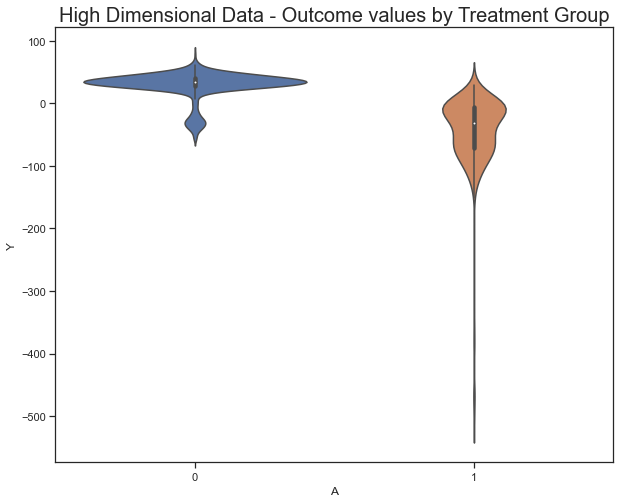

In [4]:
# visualize outcome values on high dimensional data by treatment group
sns.violinplot(x="A", y="Y", data=highdim_data)
plt.title('High Dimensional Data - Outcome values by Treatment Group', size=20)
plt.show()

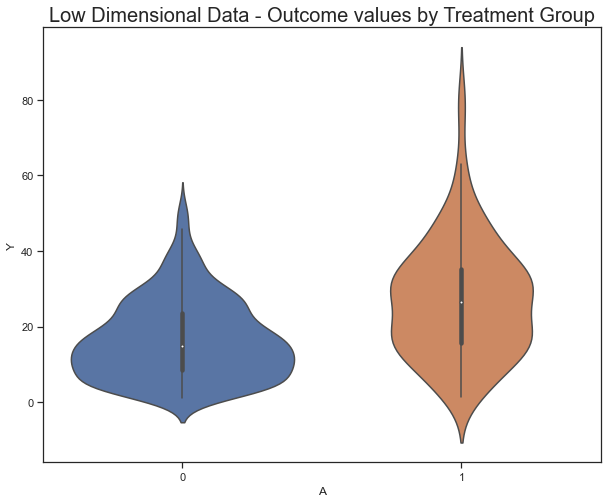

In [5]:
# visualize outcome values on low dimensional data by treatment group
sns.violinplot(x="A", y="Y", data=lowdim_data)
plt.title('Low Dimensional Data - Outcome values by Treatment Group', size=20)
plt.show()

## 3 Propensity Scores Estimation and Evaluation
We will use L1 penalized logistic regression to estimate propensity scores for both data sets.

### 3.1 Create Propensity Score Estimation Functions

In [6]:
# create a function to tune for best hyperparameters for each data set

def best_param(data, random_state, param_grid, cv=10):
    '''
    Purpose: to find the best parameter "C" (coefficient of regularization strength) for the specific dataset
    
    Parameters:
    data - dataset to best tested on 
    random_state - set seed
    param_grid - set of parameter values to test on
    cv - number of folds for cross-validation
    
    '''

    x = data.drop(['A','Y'], axis = 1)  
    y = data[['A']].values.ravel()
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=random_state)
    
    
    model_cv = GridSearchCV(LogisticRegression(penalty='l1',solver = 'liblinear'), param_grid, cv=cv)
    model_cv.fit(x_train, y_train)
    
    print("The best tuned coefficient of regularization strength is",model_cv.best_params_.get('C'), 
          "with a testing accuracy of", model_cv.score(x_test, y_test))
    
    return model_cv.best_params_.get('C')


In [7]:
def propensity_score(data, C=0.1, plot = True):
    '''
    Purpose: to estimate propensity score with L1 penalized logistic regression
    
    Parameters:
    data - dataset to estimate on 
    C - coeficient of regularization strength
    plot - print out visualization to show distribution of propensity scores
    
    Returns:
    1. ps for Propensity Score
    2. Visualization plot to show distribution of propensity scores
    
    '''
    
    T = 'A'
    Y = 'Y'
    X = data.columns.drop([T,Y])
    
    ps_model = LogisticRegression(random_state=random_state, penalty='l1',
                                  solver='liblinear').fit(data[X], data[T]) 
    
    ps = ps_model.predict_proba(data[X])[:,1] # we are interested in the probability of getting a "1"
    
    if plot:
        df_plot = pd.DataFrame({'Treatment':data[T], 'Propensity Score':ps})
        
        sns.histplot(data=df_plot, x = "Propensity Score", hue = "Treatment", element = "step")
        plt.title("Distribution of Propensity Score by Treatment Group", size=20)
        plt.show()
   
    return ps


In [8]:
# setting parameters
param_grid = {"C":[0.01,0.05,0.1,0.3,0.5,0.7,1]}

### 3.2 Evaluate Propensity Scores for High Dimensional Data

In [9]:
# use 10-fold cross-validation to tune for the best parameter for logistic regression
c_high = best_param(highdim_data, random_state=random_state, param_grid=param_grid)

The best tuned coefficient of regularization strength is 0.01 with a testing accuracy of 0.71


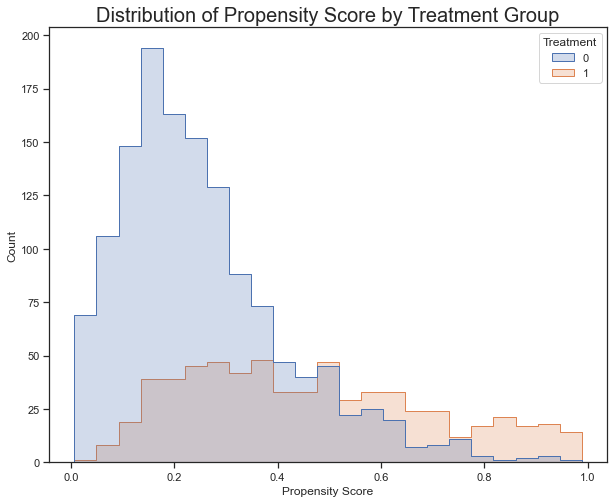

In [11]:
# estimate propsensity scores
ps_high = propensity_score(highdim_data, C = c_high)

### 3.3 Evaluate Propensity Scores for Low Dimensional Data

In [12]:
# use 10-fold cross-validation to tune for the best parameter for logistic regression
c_low = best_param(lowdim_data, random_state=random_state, param_grid=param_grid)

The best tuned coefficient of regularization strength is 0.3 with a testing accuracy of 0.8


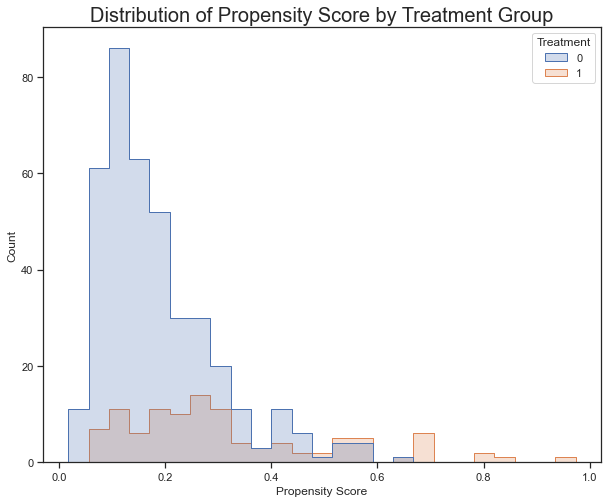

In [15]:
ps_low = propensity_score(lowdim_data, C = c_low)

## Conclusion

Propensity scores have been estimated using L1 penalized logistic regression. For algorithm testing, use ps_low for the low dimensional data and ps_high for the high dimensional data. 